# Comparison of FlowDirectors

## Introduction

Landlab directs flow and accumulates it using two types of components:

**FlowDirectors** use the topography to determine how flow moves between adjacent nodes. For every node in the grid it determines the nodes to receive flow and the proportion of flow to send from one node to its receiver. 

The **FlowAccumulator** uses the direction and proportion of flow moving between each node and (optionally) water runoff to calculate drainage area and discharge. 

The **FlowDirectors** are method specific and presently landlab supports four different methods for determining flow direction. 

1. **FlowDirectorSteepest** Flow is routed to only one node. The algorithm consideres the link slopes leaving from each node and chooses the steepest downhill link to route flow along. In the case of a raster grid, only the links are considered (Landlab differentiates between *links*, which never cross and are located at North, South, East, and West on a raster grid, and *diagonals* which cross and are located at North East, North West, South East, and South West). For raster grids, this method is also know as D4 flow routing. In the case of irregular grids, all links originating from a node are consideded.

2. **FlowDirectorD8** (raster only) Flow is only routed to one node but diagonals are also considered. 

3. **FlowDirectorMFD** Flow is directed to all nodes that are located downhill of the source node. In the case of raster grid diagonals can be included using the keyword ```diagonals=True```. Flow is partitioned between receiver nodes based on the relative slope along the links leading to the receiver nodes. The default method for partitioning is based on the sum of receiver slopes (```partition_method='slope'```). Partitioning can also be done on the basis of the square root of slope which gives the result of a steady kinematic wave(```partition_method='square_root_of_slope'```).

4. **FlowDirectorDINF** (raster only) Flow is directed to two cells based on the slope of the triangular facets that can be defined between a node and its neighbors. The steepest downhill facet is chosen and then flow is partitioned between the receiver nodes at the bottom of that facet based on the relative slopes along the facet-bounding links. 

In this tutorial we will go over more detailed examples that contrast the differences between each flow direction algorithm. For information about how to initialize and run a **FlowDirector** or the **FlowAccumulator** or , refer to the other tutorials in this section. 

First, we import the necessary python modules and make a small plotting routine. 

In [1]:
%matplotlib inline

In [2]:
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl

# import numpy
import numpy as np

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)

# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', title='Surface plot of topography'):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    color = cm.gray((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape), mg.node_y.reshape(mg.shape), 
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0., 
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## 3 topographic grids

For this tutorial we will consider four different topographic surfaces that highlight the difference between each of the flow direction algorithms. 

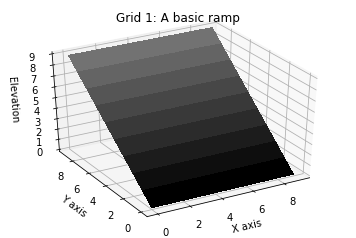

In [3]:
mg1 = RasterModelGrid((10,10), spacing=(1, 1))
_ = mg1.add_field('topographic__elevation',
                  mg1.node_y,
                  at = 'node')
surf_plot(mg1, title='Grid 1: A basic ramp')

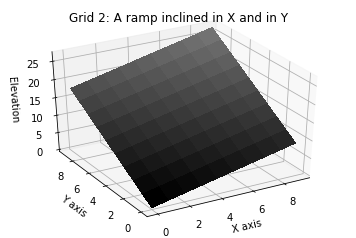

In [4]:
mg2 = RasterModelGrid((10,10), spacing=(1, 1))
_ = mg2.add_field('topographic__elevation',
                  mg2.node_x + 2.*mg2.node_y,
                  at = 'node')
surf_plot(mg2, title='Grid 2: A ramp inclined in X and in Y')

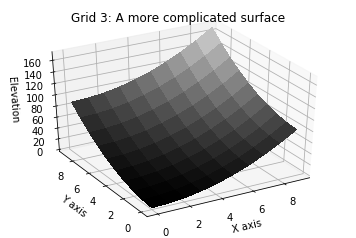

In [5]:
mg3 = RasterModelGrid((10,10), spacing=(1, 1))
_ = mg3.add_field('topographic__elevation',
                  mg3.node_x**2 + mg3.node_y**2 + mg3.node_y ,
                  at = 'node')
surf_plot(mg3, title='Grid 3: A more complicated surface')

# Comparing the different methods for each grid

We can illustrate the receiver node **FlowDirectionSteepest** has assigned to each donor node using a plotting function in Landlab called ```drainage_plot```. We will see many of these plots in this tutorial so let's take a moment to walk through the plot and what it contains. 

The background image (white to black) shows the values of topographic elevation of the underlying surface.

The color of the dots inside of each pixel show the locations of the nodes and the type of node. 

The arrows show the direction of flow, and the color shows the proportion of flow that travels along that link. 

The X on top of a node shows if that node is a local sink and flows to itself. 

Note that in Landlab *boundary nodes*, or nodes that are on the edge of a grid do not have area and do not contribute flow to nodes. These nodes can either be *Fixed Gradient Nodes*, *Fixed Value Nodes*, or *Closed Nodes*. With the exception of *Closed Nodes* the boundary nodes can receive flow. 

An important step in all flow direction and accumulation is setting the proper boundary condition. Refer to the boundary condition tutorial for more information. 


## Grid 1: Basic Ramp

As with the Introduction to Flow Director tutorial, let's start with the basic ramp. 

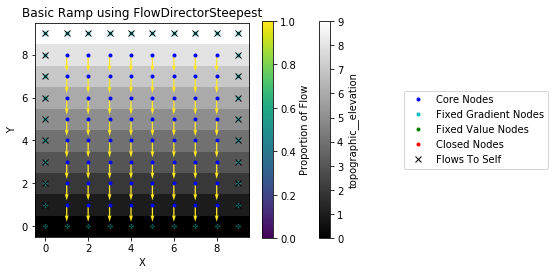

In [6]:
fd = FlowDirectorSteepest(mg1, 'topographic__elevation')
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorSteepest')

Reassuringly we can see that the flow is being sent from high elevations at the top of the grid to low elevations at the bottom of the grid. We can also see that all of the arrows are yellow, and thus all of the flow is traveling on these links. 

Now let's see how the other **FlowDirectors** direct the flow on this simple grid. We don't need to specify the surface so long as it is the field ```'topographic__elevation'```.

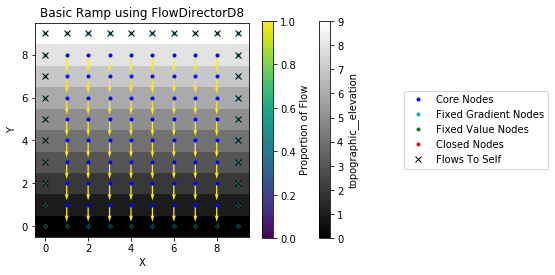

In [7]:
fd = FlowDirectorD8(mg1)
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorD8')

For this ramp, the steepest slope is down a link, and not a diagonal, so **FlowDirectorD8** gives the same result as **FlowDirectorSteepest**.

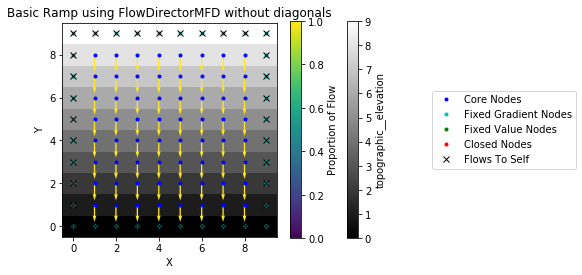

In [8]:
fd = FlowDirectorMFD(mg1, diagonals=False) # diagonals=False is the default option
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorMFD without diagonals')

Similarly, while there is more than one node below each core node, there is only one node that is connected by a link and not a diagonal. Thus **FlowDirectorMFD** with the keyword ```diagonals``` set to ```True``` provides the same results as **FlowDirectorSteepest** and **FlowDirectorD8**

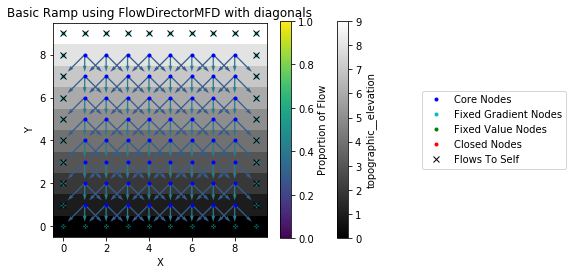

In [9]:
fd = FlowDirectorMFD(mg1, diagonals=True)
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorMFD with diagonals')

When we permit flow along diagonal connections between nodes and flow to all downhill nodes, we see a difference in the directing pattern on this simple ramp. The flow is partitioned between the three downhill nodes, and there is more flow being sent to along the link as compared with the diagonals (the links are a lighter color blue than the diagonals). 

One issue we might have with the results from **FlowDirectorMFD** in this case is that the flow on the diagonals crosses. This is one of the problems with using diagonal connections between nodes. 


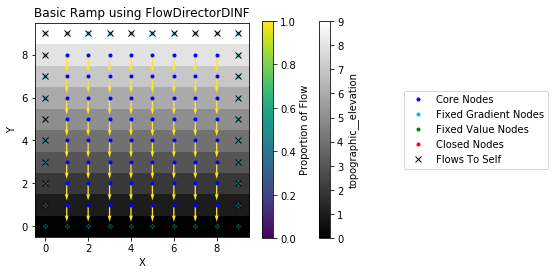

In [10]:
fd = FlowDirectorDINF(mg1)
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorDINF')

In **FlowDirectorDINF** flow is partitioned to two nodes based on steepness of the eight triangular facets surrounding each node. The partitioning is based on the relation between the link and diagonal slope that form the edge of the facet and the slope of the facet itself. When one of the facet edges has the same slope as the facet, as is the case in this ramp example, all of the flow is partitioned along that edge. 

## Grid 2: Inclined plane in two dimentions

Next lets look at all the flow directors but with the inclined plane. Recall that this plane is tilted in both X and Y axes, and that is tilted more steeply in the Y direction. 

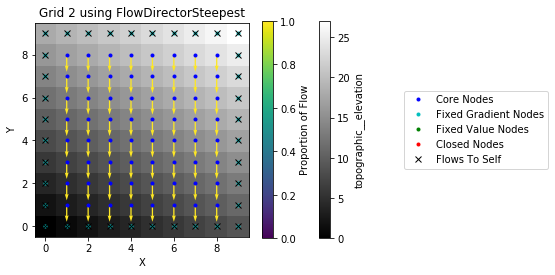

In [11]:
fd = FlowDirectorSteepest(mg2, 'topographic__elevation')
fd.run_one_step()
plt.figure()
drainage_plot(mg2, title='Grid 2 using FlowDirectorSteepest')

Flow is directed down parallel to to the the Y-axis of the plane. This makes sense in the context of the **FlowDirectorSteepest** algorithm; it only sends flow to one node, so it an idealized geometry such as the plane in this example, it provides flow direction that is non-realistic. 

As we will discuss throughout this tutorial, there are benefits and drawbacks to each **FlowDirector** algorithm. 

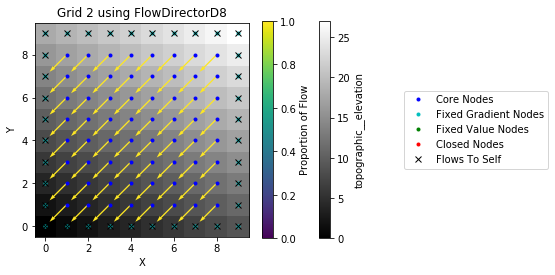

In [12]:
fd = FlowDirectorD8(mg2)
fd.run_one_step()
plt.figure()
drainage_plot(mg2, title='Grid 2 using FlowDirectorD8')

**FlowDirectorD8** consideres the diagonal connections between nodes. As the plane is inclined to the southwest the flow direction looks better here, though as we will see later, sometimes **FlowDirectorD8** does non-realistic directing too. 

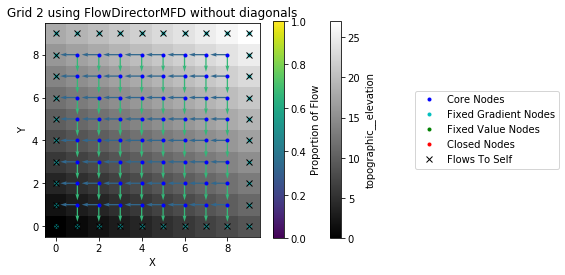

In [13]:
fd = FlowDirectorMFD(mg2, diagonals=False) # diagonals=False is the default option
fd.run_one_step()
plt.figure()
drainage_plot(mg2, title='Grid 2 using FlowDirectorMFD without diagonals')

As **FlowDirectorMFD** can send flow to all the nodes downhill it doesn't have the same problem that **FlowDirectorSteepest** had. Because the plane is tilted down more steeply to the south than to the east, it sends more flow on the steeper link. 

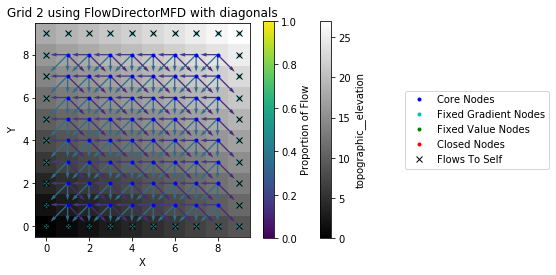

In [14]:
fd = FlowDirectorMFD(mg2, diagonals=True)
fd.run_one_step()
plt.figure()
drainage_plot(mg2, title='Grid 2 using FlowDirectorMFD with diagonals')

When **FlowDirectorMFD** considers diagonals in addition to links, we see that it sends the flow to four nodes instead of three. While all of the receiver nodes are downhill from their donor nodes, we see again that using diagonals permits flow to cross itself. We also see that the most flow is routed to the south and the south east, which makes sense based on how the plane is tilted. 

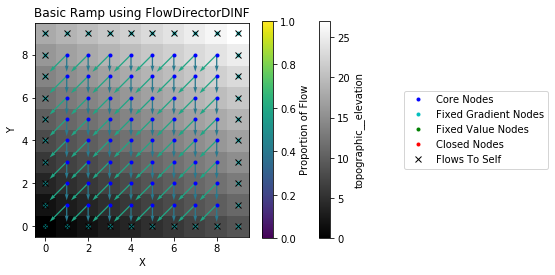

In [15]:
fd = FlowDirectorDINF(mg2)
fd.run_one_step()
plt.figure()
drainage_plot(mg2, title='Basic Ramp using FlowDirectorDINF')

Here **FlowDirectorDINF** routes flow in two directions, to the south and southeast. The plane is steeper to from north to south than from east to west and so more flow is directed on the diagonal to the southeast. 

## Grid 3: Curved surface

Finally, lets consider our curved surface. 

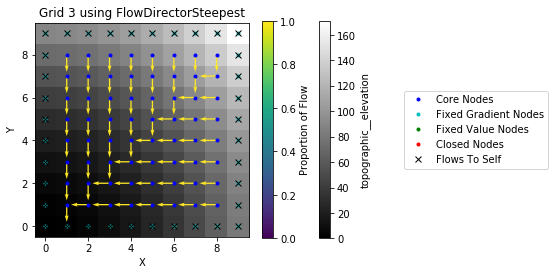

In [16]:
fd = FlowDirectorSteepest(mg3, 'topographic__elevation')
fd.run_one_step()
plt.figure()
drainage_plot(mg3, title='Grid 3 using FlowDirectorSteepest')

Flow on this surface using **FlowDirectorSteepest** looks realistic, as flow is routed down into the bottom of the curved surface. 

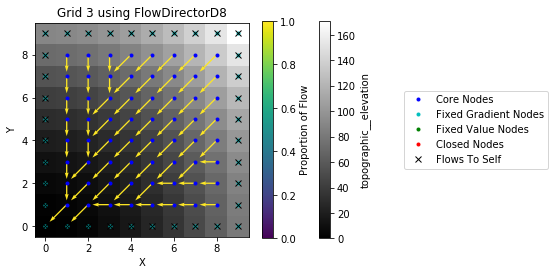

In [17]:
fd = FlowDirectorD8(mg3)
fd.run_one_step()
plt.figure()
drainage_plot(mg3, title='Grid 3 using FlowDirectorD8')

Near the bottom left of the grid, the steepest descent is on a diagonal, so using **FlowDirectorD8** gives a different drainage pattern. 

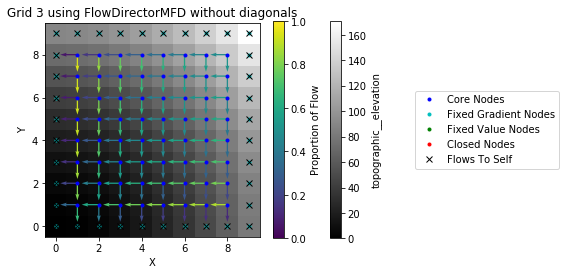

In [18]:
fd = FlowDirectorMFD(mg3, diagonals=False) # diagonals=False is the default option
fd.run_one_step()
plt.figure()
drainage_plot(mg3, title='Grid 3 using FlowDirectorMFD without diagonals')

Permitting multiple receivers with and without diagonals give an additional two different drainage patterns. 

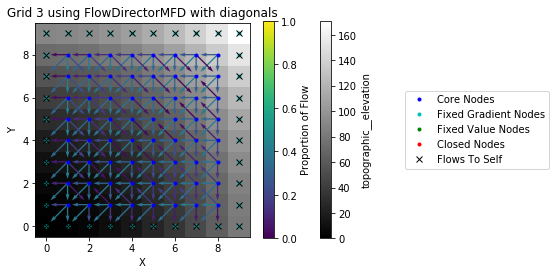

In [19]:
fd = FlowDirectorMFD(mg3, diagonals=True)
fd.run_one_step()
plt.figure()
drainage_plot(mg3, title='Grid 3 using FlowDirectorMFD with diagonals')

Again we see flow paths crossing when we permit consideration of flow along the diagonals. 

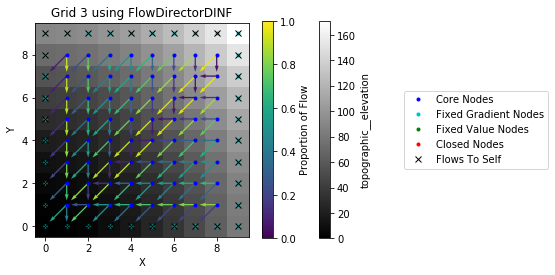

In [20]:
fd = FlowDirectorDINF(mg3)
fd.run_one_step()
plt.figure()
drainage_plot(mg3, title='Grid 3 using FlowDirectorDINF')

Finally we see yet a different drainage pattern when we use **FlowDirectorDINF** and flow is routed along an adjacent diagonal-link pair.

## Comparison of Accumulated Area

Before concluding, lets examine the accumulated drainage area using each of the **FlowDirector** methods and the third grid. For an introduction to creating and running a **FlowAccumulator** see the tutorial "Introduction to Flow Accumulators". 

Often we do flow routing and accumulation because we want to use the accumulated area as a proxy for the water discharge. So the details of how the flow is routed are important because they influence how the drainage area pattern evolves. 

Lets begain with **FlowDirectorSteepest**.

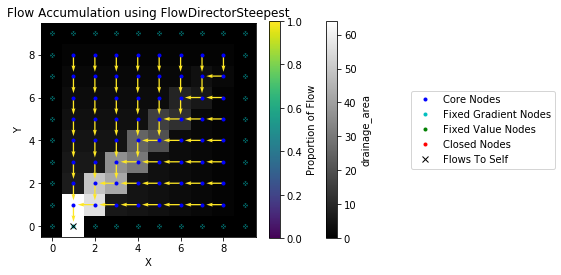

In [21]:
from landlab.components import FlowAccumulator

mg3 = RasterModelGrid((10,10), spacing=(1, 1))
_ = mg3.add_field('topographic__elevation',
                  mg3.node_x**2 + mg3.node_y**2 + mg3.node_y ,
                  at = 'node')

fa = FlowAccumulator(mg3, 'topographic__elevation', flow_director='Steepest')
fa.run_one_step()
plt.figure()
drainage_plot(mg3, 'drainage_area', title='Flow Accumulation using FlowDirectorSteepest')

Here we see that flow has accumulated into one channel in the bottom of the curved surface. 

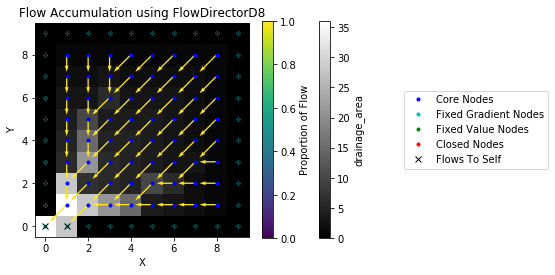

In [22]:
fa = FlowAccumulator(mg3, 'topographic__elevation', flow_director='D8')
fa.run_one_step()
plt.figure()
drainage_plot(mg3, 'drainage_area', title='Flow Accumulation using FlowDirectorD8')

When diagonals are considered, as in **FlowDirectorD8**, the drainage patter looks very diferent. Instead of one channel we have two smaller channels. 

In [23]:
fa = FlowAccumulator(mg3, 'topographic__elevation', flow_director='MFD')
fa.run_one_step()
plt.figure()
drainage_plot(mg3, 'drainage_area', title='Flow Accumulation using FlowDirectorMFD without diagonals')

ValueError: could not broadcast input array from shape (180,2) into shape (180)

Flow is distributed much more when we use **FlowDirectorMFD**.

In [ ]:
fa = FlowAccumulator(mg3, 'topographic__elevation', flow_director='MFD', diagonals=True)
fa.run_one_step()
plt.figure()
drainage_plot(mg3, 'drainage_area', title='Flow Accumulation using FlowDirectorMFD with diagonals')

Adding diagonals to **FlowDirectorMFD** gives a channel somewhat similar to the one created by **FlowDirectorSteepest** but much more distributed. 

In [ ]:
fa = FlowAccumulator(mg3, 'topographic__elevation', flow_director='DINF')
fa.run_one_step()
plt.figure()
drainage_plot(mg3, 'drainage_area', title='Flow Accumulation using FlowDirectorDINF')

Finally, **FlowDirectorDINF** gives yet another pattern for the accumulation of drainage area.


# Conclusion

This tutorial compared the different methods in more detail and over surfaces that are more complicated than a simple sloping ramp. It also described how these different **FlowDirector** methods change the patterns of accumulated drainage area. 

Next consider one of two additional tutorials about directing and accumulating flow in Landlab.

1. **Introduction to FlowDirector**: A tutorial that goes over the different **FlowDirectors** present in Landlab and how to create and run a **FlowDirector**.
2. **Introduction to FlowAccumulator**: A tutorial that describes how to use the **FlowAccumulator**.